In [241]:
import polars as pl 
import numpy as np 
import pandas as pd 
import glob 
import os
import seaborn as sns 
import matplotlib.pyplot as plt 

In [242]:
dir_path = '/Users/jack/Desktop/VN1 Forecasting Competition'


all_files = glob.glob(os.path.join(dir_path,'*.csv'))

#read sales 

sales = pl.read_csv('/Users/jack/Desktop/VN1 Forecasting Competition/Phase 0 - Sales.csv')

price = pl.read_csv('/Users/jack/Desktop/VN1 Forecasting Competition/Phase 0 - Price.csv')

price_new = pl.read_csv('/Users/jack/Desktop/VN1 Forecasting Competition/Phase 1 - Price.csv')

sales_new = pl.read_csv('/Users/jack/Desktop/VN1 Forecasting Competition/Phase 1 - Sales.csv')

#sample_submission = pl.read_csv('/Users/jack/Desktop/VN1 Forecasting Competition/Submission Phase 1 - Random (3).csv')

In [243]:
sales_df = sales#.join(sales_new,
          # on=['Client','Warehouse','Product'])

price_df = price#.join(
   # price_new,
   # on=['Client','Warehouse','Product']
#)

In [244]:
sales # melt data 

def preprocess_data(df): 

    '''develop function to transform data'''
    
    new_df = (df
    
    .melt(id_vars=['Client','Warehouse','Product'],
    
            variable_name='ds',
    
            value_name='y')

            .with_columns(pl.col('ds').str.to_date(format = '%Y-%m-%d'))
            
            )
    

    return new_df

df = preprocess_data(sales_df)

prices_ = preprocess_data(price_df)

In [245]:
val_set = preprocess_data(sales_new)

val_prices = preprocess_data(price_new)

In [246]:
print(f"Unique Clients: {df['Client'].n_unique()}, Unique Warehouses: {df['Warehouse'].n_unique()}, Unique Products: {df['Product'].n_unique()}") # wow, 11k products? hmmmmmm


print(f'Minimum Date of Data: {df["ds"].min()}, Maximum Date of Data: {df["ds"].max()}')

Unique Clients: 46, Unique Warehouses: 328, Unique Products: 11171
Minimum Date of Data: 2020-07-06, Maximum Date of Data: 2023-10-02


<Axes: title={'center': 'Most Products Have Intermittency'}, ylabel='Frequency'>

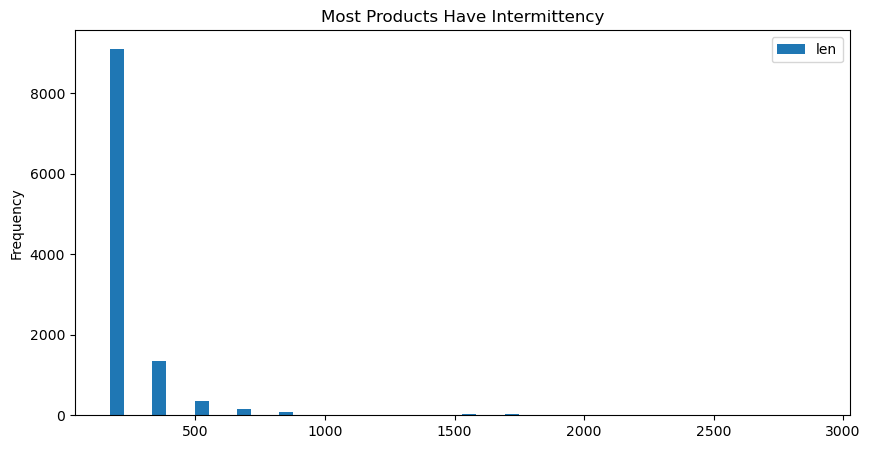

In [247]:
df.group_by('Product').len().sort('len') # sum products have little history and others have tons 

df.group_by('Product').len().to_pandas().plot.hist(y='len',
                                                   bins=50,
                                                   title='Most Products Have Intermittency')

In [248]:
agg = (
    df
    .sort('ds')
    .group_by_dynamic(
        index_column='ds',
        every='1w',
        group_by=['Client','Warehouse','Product']
    )

    .agg(pl.col('y').sum())
)

agg

Client,Warehouse,Product,ds,y
i64,i64,i64,date,f64
0,1,367,2020-07-06,7.0
0,1,367,2020-07-13,7.0
0,1,367,2020-07-20,7.0
0,1,367,2020-07-27,7.0
0,1,367,2020-08-03,7.0
…,…,…,…,…
46,318,14294,2023-09-04,4.0
46,318,14294,2023-09-11,3.0
46,318,14294,2023-09-18,5.0


In [249]:
#data may not be missing but zero demand means no sales, so lets inspect that 


agg.filter(pl.col('y') == 0) # we have 1.8 million records with zero sales, interesting.... 

#add out of season indicator 
agg = agg.join(prices_.rename({'y':'price'}),
         on=['Client','Warehouse','Product','ds']).with_columns(out_of_season = pl.when(pl.col('price').is_null()).then(1).otherwise(0),
                                                                unique_id =  pl.concat_str('Client','Warehouse','Product',separator='-'))

#get proportion of time out of season by each unique combo
oos = agg.group_by(['unique_id','Client','Warehouse','Product']).agg(pl.col('out_of_season').mean().alias('avg_out_of_season'),
                                                         pl.col('out_of_season').sum().alias('total_out_of_season')).sort('total_out_of_season',descending=True)


total_days_oos = agg['ds'].dt.date().max() - agg['ds'].dt.date().min() # its actually 169 weeks 

print(f'Maximum Total Days out of Stock/With No Transactions is= {total_days_oos}')

Maximum Total Days out of Stock/With No Transactions is= 1183 days, 0:00:00


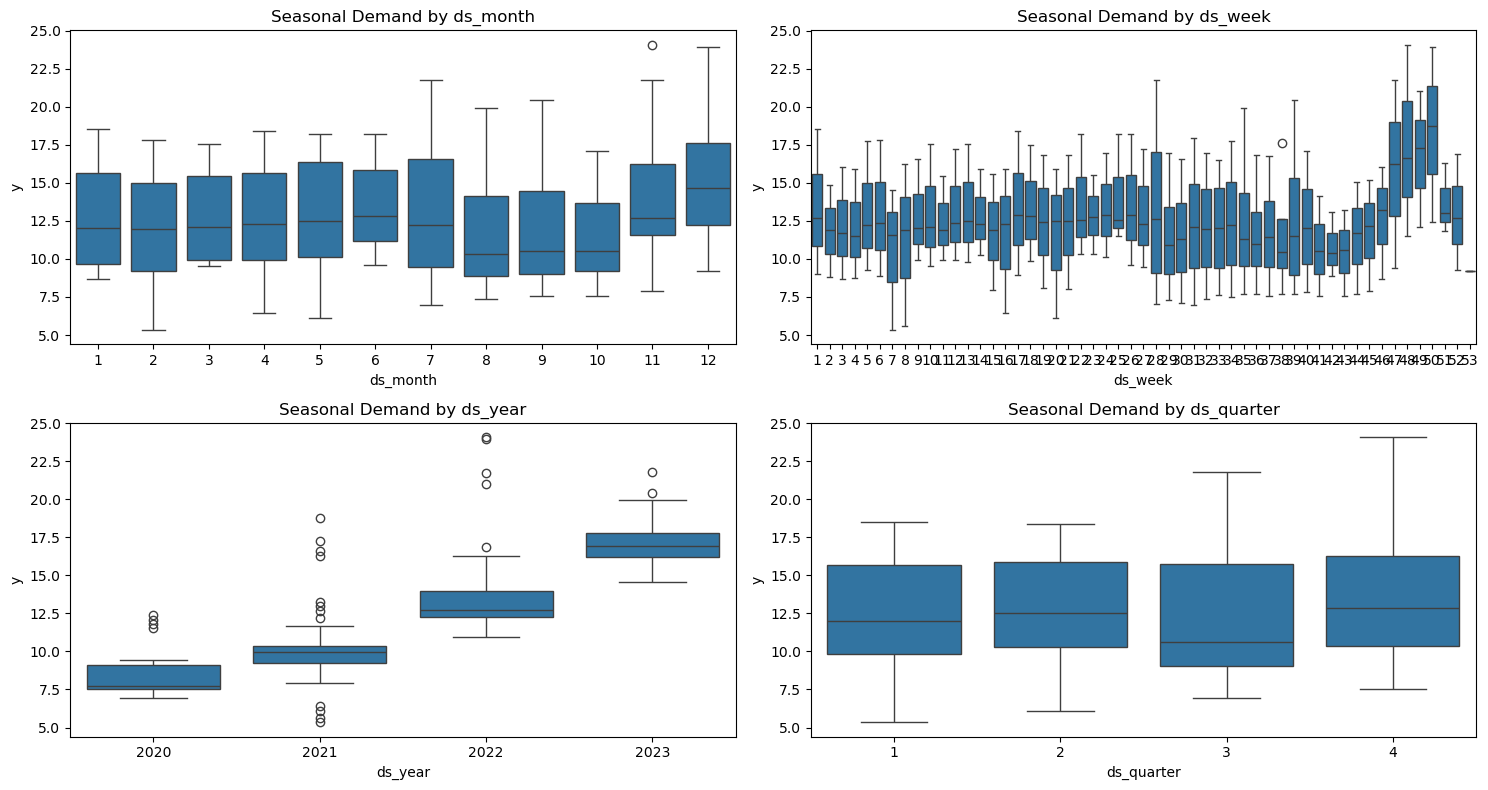

In [250]:
# seasonality plots 

from feature_engine.datetime import DatetimeFeatures 

dt_trns = DatetimeFeatures(variables=['ds'],

features_to_extract=['month','week','year','quarter'])


#pull avg sales and prices to examine seasonality 
ts = (df.join(prices_.rename({'y':'price'}),

on=['Client',"Warehouse",'Product','ds'])

.with_columns(pl.col('price').cast(pl.Float64))

.group_by_dynamic(index_column='ds',

every='1w'

).agg(pl.col('y').mean(),

pl.col('price').mean()

).to_pandas())



#grab date feats 
new = dt_trns.fit_transform(ts)

ds_cols = [x for x in new.columns if 'ds' in x]


#plot
import seaborn as sns 

fig, ax = plt.subplots(figsize=(15,8),
ncols=2,
nrows=2)

ax = ax.flatten()

for idx, col in enumerate(ds_cols):

    sns.boxplot(new,
    x=col,
    y='y',
    #hue='ds_year',
    ax=ax[idx]).set_title(f'Seasonal Demand by {col}')

plt.tight_layout()

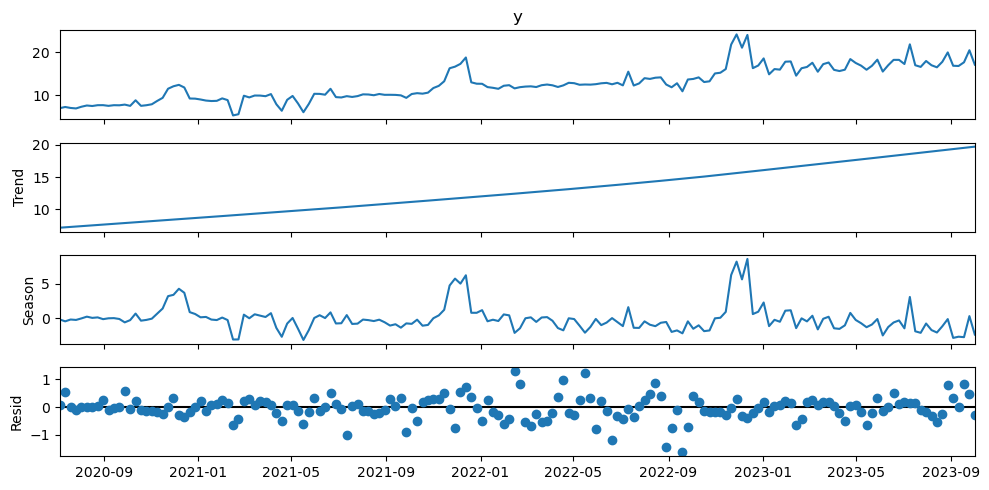

In [251]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

plt.rc('figure',figsize=(10,5))

stl_res = STL(ts.set_index('ds')['y'],
              period=52).fit()

stl_res.plot()

plt.tight_layout()

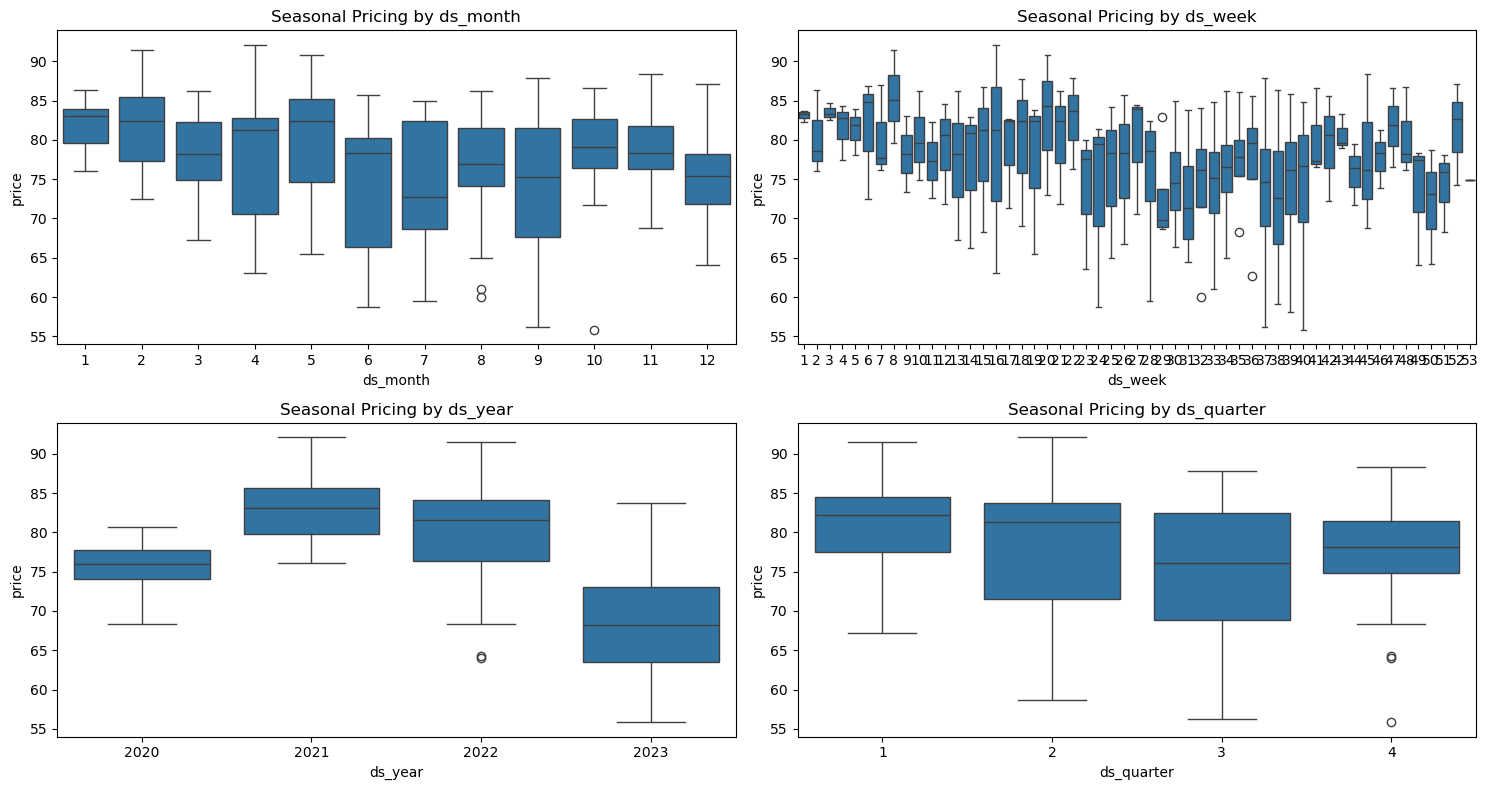

In [252]:

fig, ax = plt.subplots(figsize=(15,8),
ncols=2,
nrows=2)

ax = ax.flatten()

for idx, col in enumerate(ds_cols):

    sns.boxplot(new,
    x=col,
    y='price',
    #hue='ds_year',
    ax=ax[idx]).set_title(f'Seasonal Pricing by {col}')

plt.tight_layout()

Number of Items with Less Than or Equal to 10 Transactions: 4734


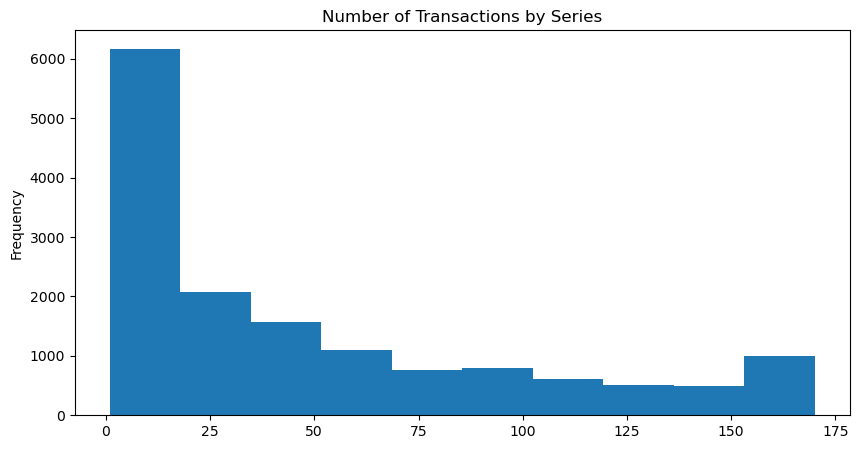

In [253]:
df = df.with_columns(pl.concat_str('Client','Warehouse','Product',separator='-').alias('unique_id'))

num_purchase = (
    df.filter(pl.col('y') > 0)
    
    
    .group_by('unique_id')

    .agg(
        
        pl.col('y').count().alias("num_transactions"),

        pl.col('y').sum().alias("total_demand"),
         
         pl.col('ds').max().alias("last_sale_date"))
                                                ).sort("last_sale_date").to_pandas()

plt.title('Number of Transactions by Series')

num_purchase['num_transactions'].plot.hist()

num_purchase.describe()

print(f'Number of Items with Less Than or Equal to 10 Transactions: {num_purchase[num_purchase["num_transactions"] <= 10].shape[0]}')

# we will hold these out for intermittent demand models like croston, IMAPA, ADIDA 

# Make TsFeatures: Exploring Timeseries using statistical features 

In [254]:
# from tsfeatures import tsfeatures

# ts_feats = tsfeatures(df.to_pandas(),
#            freq=52)

In [255]:

# #looks like we have lots of series with a strong acf at lag1
# plt.style.use('ggplot')
# plt.rcParams.update(**{'figure.dpi':150})

# # Set the theme for the plot
# sns.set_theme(style="whitegrid")


# fig, ax = plt.subplots(figsize=(12,5),
#                        ncols=2,
#                        sharey=True
#                        )

# fig.suptitle('Feature Based EDA of All Series')

# ax[0].set_title('ACF1 at 1st Difference')
# ax[1].set_title('Yearly Seasonal Strength')

# ts_feats.plot.hist(y='diff1_acf1',
#                    bins=100,
#                    ax=ax[0])

# ts_feats.plot.hist(y='seasonal_strength',
#                    bins=100,
#                    ax=ax[1])

In [256]:
# total_dmd = df.group_by('unique_id').agg(pl.col('y').sum()).to_pandas() # get total mean sales per week 

# ts_feats_ = ts_feats.merge(
#     total_dmd,
#     on=['unique_id']
# )

In [257]:
# one_time_sale_ids = ts_feats_.query('y <= 5')['unique_id'].unique()

# df.filter(pl.col('unique_id').is_in(one_time_sale_ids)).filter(pl.col('y') != 0).sort('ds') # 4573 ids have sold less than 5 units ever....

In [258]:
num_purchase['last_purchase_year'] = num_purchase['last_sale_date'].dt.year

In [259]:
# #filter for "sparse Ids"

# sparse_ids = num_purchase.query('last_purchase_year < 2023 | num_transactions == 1')['unique_id'].unique()

# #creat uid column in val set 
# val_set = val_set.with_columns(pl.concat_str('Client','Warehouse','Product',separator='-').alias('unique_id'))


# pct_demand_lost = val_set.filter(pl.col('unique_id').is_in(sparse_ids))['y'].sum() / val_set['y'].sum()

# print(f'% Of Demand with Ids Last sold in 2023 or A single transaction: {pct_demand_lost*100:.2f}')

In [260]:
# speciality_skus = df.filter(pl.col('unique_id').is_in(one_time_sale_ids))


# speciality_skus.unique(subset=['unique_id'])['Client'].value_counts().sort('count',descending=True)


# speciality_skus.with_columns(pl.col('y').mean().over('unique_id').alias('mean_transaction'))

* Make Holiday And Stockout Features

In [261]:
from mlforecast.feature_engineering import transform_exog
from mlforecast.lag_transforms import ExpandingMean

def transform_prices(price_df,target_df):

    price_df = price_df.with_columns(

            pl.concat_str(['Client','Warehouse','Product'], 
                          
                          separator='-').alias('unique_id').cast(pl.Categorical))
        
    target_df = target_df.with_columns(

            pl.concat_str(['Client','Warehouse','Product'], 
                          
                          separator='-').alias('unique_id').cast(pl.Categorical))

    #engineer features from prices 
    prices_new = price_df.with_columns(
                        pl.col('y').cast(pl.Float64).alias('price'))


    #get exog price features 
    exog_prices = (transform_exog(df=prices_new[['unique_id','ds','price']],
                
                lags=[1],
                
                lag_transforms={1:[ExpandingMean()]})

                .with_columns(pl.when((pl.col('price_lag1').diff().over('unique_id') != 0) & (pl.col('price_lag1') != 0) 
                                      
                                      & (pl.col('price_lag1').is_not_null()) & (pl.col('price_lag1').diff().over('unique_id').is_not_null()))
                              
                              .then(pl.col('price_lag1').diff().over('unique_id')).otherwise(0).fill_nan(0).alias('price_diff'),
                              
                              pl.when(pl.col('price_lag1') != 0).then(pl.col('price_lag1').diff().over('unique_id') / pl.col('price_lag1')).otherwise(0).alias('price_diff_rel'))
                              
                              .with_columns(pl.col('price_diff').shift(4).over('unique_id').alias('monthly_price_shift'),
                                            pl.col('price_lag1').shift(52).over('unique_id').alias('ly_price_shift'),
                                            pl.col('price_diff').shift(52).over('unique_id').alias('ly_price_diff')
                                            )
                              
                              
                              .drop('price').rename({'price_lag1':'price'})).fill_null(strategy='backward')


    exog_prices_filled = (exog_prices

    #fill with mean imputation over unique_id, week
    .with_columns(pl.col("price").fill_nan(None),
                  pl.col('monthly_price_shift').fill_nan(None),
                  pl.col('price_diff_rel').fill_nan(None))

    #fill with forward filling, over unique_id 
    .with_columns(pl.col("price"),
                  pl.col('monthly_price_shift'),
                  pl.col('ly_price_shift'))

    #fill with mean of that item
    #.with_columns(pl.col("price").fill_null(strategy='mean').over("unique_id"))

    )
    
    #get product level global prices and revenue
    agg = prices_new.group_by_dynamic(index_column='ds',
                                every='1w',
                                group_by='Client').agg(pl.col('price').mean().alias("mean_price_client"))
    
    agg_client = transform_exog(df=agg,
                            lags=[1,4],
                            #lag_transforms={1:[ExpandingMean()]},
                            id_col='Client').drop('mean_price_client')


    #get product level global prices and revenue
    agg = prices_new.group_by_dynamic(index_column='ds',
                                every='1w',
                                group_by='Product').agg(pl.col('price').mean().alias("mean_price_product"))

    agg_product = transform_exog(df=agg,
                            lags=[1,4],
                            #lag_transforms={1:[ExpandingMean()]},
                            id_col='Product').drop('mean_price_product')
    
    #join prices to target 
    final_price_df = target_df.join(
        
                                    exog_prices_filled,
                                            on=['unique_id','ds']
                                                                ).join(
                                                                                        agg_product,
                                                                                        on=['Product','ds']
                                                                                                            ).join(
                                                                                                                agg_client,
                                                                                                                on=['Client','ds']
                                                                                                            )
    

    #engineer relative category delta features 

    final_price_df = final_price_df.with_columns((pl.col('price') - pl.col('mean_price_product_lag1')).alias('prod_id_price_delta'))
    


    return final_price_df

In [262]:
# define evaluation function 
def score_model(y_true,y_pred):

     # Convert inputs to numpy arrays to ensure compatibility
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # Calculate absolute error and raw error
    abs_err = np.nansum(np.abs(y_pred - y_true))
    err = np.nansum(y_pred - y_true)
    
    # Combine errors
    score = abs_err + np.abs(err)
    
    # Normalize by the total sum of true values
    total_true_sum = np.nansum(y_true)
    
    # Avoid division by zero
    if total_true_sum == 0:
        return np.nan  # or return 0, depending on how you want to handle this case
    
    score /= total_true_sum
    
    return score

In [263]:
# define a few date indicators for holiday weeks 

from datetime import datetime, timedelta

def week_contains_christmas(dates):
    """Check if the week contains Christmas (December 25th)"""
    return (dates.to_series().dt.month == 12) & (dates.to_series().dt.day.between(19, 25))


In [264]:
# lets do some initial modeling
from mlforecast import MLForecast
from mlforecast.lag_transforms import (RollingMean,
                                       ExponentiallyWeightedMean, SeasonalRollingMean,
                                       RollingQuantile,SeasonalRollingStd,ExpandingMean,Combine,SeasonalRollingMax)
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor


#OUTLINE FORECAST HORIZON 
horizon = 13

#CUSTOM WINDOW FUNCTIONS USING NUMBA/Nixtla
from numba import njit 
from window_ops.rolling import rolling_kurtosis, rolling_average_days_with_sales, rolling_cv
from window_ops.shift import shift_array
import operator 

@njit
def rolling_skew(x, window_size):
    n = len(x)
    result = np.empty(n)
    result[:] = np.nan
    for i in range(window_size - 1, n):
        window = x[i - window_size + 1 : i + 1]
        mean = np.mean(window)
        std = np.std(window)
        skew = np.mean(((window - mean) / std) ** 3) if std != 0 else 0
        result[i] = skew
    return result

@njit
def cumulative_proportion_zeros(x):
    """Computes the cumulative proportion of zeros in the array"""
    cumulative_zeros = np.cumsum(x == 0)
    total_observations = np.arange(1, len(x) + 1)
    return cumulative_zeros / total_observations


@njit
def rolling_nonzero_count(x, window_size):
    result = np.zeros_like(x)
    for i in range(len(x)):
        count = 0
        for j in range(max(0, i - window_size + 1), i + 1):
            if x[j] != 0:
                count += 1
        result[i] = count
    return result

@njit
def cumulative_zero_count(x):
    return (x == 0).cumsum()


@njit
def days_since_last_sale(x):
    count = 0
    result = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] > 0:
            count = 0
        else:
            count += 1
        result[i] = count
    return result


@njit
def count_positive_reset_on_zero(x):
    count = 0
    result = np.zeros_like(x)
    for i in range(len(x)):
        if i > 0 and x[i-1] == 0:
            count = 0
        if x[i] > 0:
            count += 1
        result[i] = count
    return result

@njit
def avg_interval_consecutive_zeros(x, window_size):
    result = np.zeros_like(x)
    for i in range(len(x)):
        if i < window_size:
            continue
        window = x[i-window_size:i]
        zero_intervals = []
        current_interval = 0
        for val in window:
            if val == 0:
                current_interval += 1
            elif current_interval > 0:
                zero_intervals.append(current_interval)
                current_interval = 0
        if current_interval > 0:
            zero_intervals.append(current_interval)
        # Calculate mean manually
        if zero_intervals:
            result[i] = sum(zero_intervals) / len(zero_intervals)
        else:
            result[i] = 0
    return result


@njit
def seasonal_exp_rolling_mean(x, season_length, alpha):
    result = np.zeros_like(x)
    for i in range(len(x)):
        if i < season_length:
            result[i] = x[i]
        else:
            result[i] = alpha * x[i] + (1 - alpha) * result[i - season_length]
    return result

mlf = MLForecast(
    models = {'lgb':LGBMRegressor(objective='tweedie',
                                  eval_metric='tweedie',
                                  importance_type='gain',
                                  categorical_feature = [0,1,2],
                                  verbosity=-1,
                                  random_state=42)},

    freq='W-MON',

    lags = [1,2,3,4,13,26,52],

    lag_transforms={1:[
                       
                       ExponentiallyWeightedMean(alpha=.2),

                       ExponentiallyWeightedMean(alpha=.5),

                       ExponentiallyWeightedMean(alpha=.1),

                                   RollingMean(window_size=13,
                                               min_samples=1),

                                               RollingMean(window_size=52,
                                                           min_samples=1),

                                                           (rolling_cv,13),

                                                           (rolling_cv,52),

                                            SeasonalRollingMean(season_length=13,
                                                                window_size=4,
                                                                min_samples=1),
                                                        
                (rolling_average_days_with_sales,52),

                (rolling_average_days_with_sales,13),

                (rolling_skew,52),

                (rolling_skew,4),

                (rolling_skew,13), # capture long(er) term seasonal flucuations in the demand distribution 
                
                   cumulative_proportion_zeros,
                    
                    cumulative_zero_count,

                    (avg_interval_consecutive_zeros,13),

                    (avg_interval_consecutive_zeros,52),

                    days_since_last_sale,

                    (rolling_nonzero_count,4),

                    count_positive_reset_on_zero,

                        SeasonalRollingStd(window_size=4,
                        season_length=13,
                        min_samples=1),

                        SeasonalRollingMax(window_size=4,
                                           season_length=13,
                                           min_samples=1)
                    
                    ]},


    date_features=['week','month','quarter','year',week_contains_christmas],

    num_threads=8
)


In [265]:
train_agg = agg.filter(pl.col('ds').dt.year() != 2023) # look at only train set 



#slice for items not assorted for 3 years in a row before 2023: (we never sold a unit in that week in history )

not_asst = (train_agg.group_by(['unique_id',

pl.col('ds').dt.week().alias('week')])

.agg(pl.col('out_of_season').sum(),

pl.col('unique_id').len().alias('num_years_assorted'),


pl.col('y').sum())


.filter((pl.col('out_of_season') == pl.col('num_years_assorted')) & (pl.col('out_of_season') > 2) & (pl.col('week') != 53)) # week can't be 53, it looks like we had a leap year 

.with_columns(pl.lit(1).alias('not_assorted_week'),

pl.col('unique_id').cast(pl.Categorical))).select('unique_id','week','not_assorted_week').unique(subset=['unique_id','week'])

# Feature Engineering 

In [266]:
import datetime 

def make_holiday_counter(df,holiday_day,holiday_month, holiday_name):

    new = (df
    
    .with_columns(pl.col('ds').dt.year()  # Extract year from the 'ds' column
            
            
            .map_elements(lambda year: datetime.date(year, holiday_month,holiday_day))  # Create Christmas date for that year
            
            
            .alias(f'{holiday_name}_date'))
            
            .pipe(lambda df: df.with_columns((pl.col(f'{holiday_name}_date') - pl.col('ds')).dt.total_days().alias(f'days_until_{holiday_name}')))
            
            ).drop(f'{holiday_name}_date')
    

    return new 


df_ = make_holiday_counter(df=df,
                     holiday_day=25,
                     holiday_month=12,
                     holiday_name='christmas')


new_df = transform_prices(prices_,
                           df_)


no_asst = (agg.group_by(['unique_id',

pl.col('ds').dt.week().alias('week')])

.agg(pl.col('out_of_season').sum(),

pl.col('unique_id').len().alias('num_years_assorted'),


pl.col('y').sum())


.filter((pl.col('out_of_season') == pl.col('num_years_assorted')) & (pl.col('out_of_season') > 1) & (pl.col('week') != 53))

.with_columns(pl.lit(1).alias('not_assorted'),

pl.col('unique_id').cast(pl.Categorical)))



# #make radial basis functions to capture cyclicality 
# def rbf_features(target_df, week_data, centers, epsilon=1):
#     """
#     Generate RBF features.
#     :param week_data: The week values.
#     :param centers: The center weeks for the RBFs.
#     :param epsilon: Spread parameter for the RBFs.
#     :return: RBF feature matrix.
#     """

#     rbf_terms = np.array([np.exp(-((week_data - c) ** 2) / (2 * epsilon ** 2)) for c in centers]).T

#     rbf_df = pl.from_pandas(pd.DataFrame(rbf_terms, columns=[f'RBF_week_{c}' for c in centers]))

#     return pl.concat([target_df,rbf_df],how='horizontal')

# # # Define centers around December and January (e.g., week 48 to week 4)
# key_weeks = [8,28,35,40,52]  # Last weeks of the year and first weeks of January

# # Generate RBF features
# new_df = rbf_features(new_df,new_df['ds'].dt.week(), key_weeks,epsilon=1)


#it looks like these product have never been sold in these weeks every year they have been assorted, hence we can create a feature from this
# 
#  we tag all items with this property as "seasonal items"

seasonal_items = (agg.group_by(['unique_id',

pl.col('ds').dt.week().alias('week')])

.agg(pl.col('out_of_season').sum(),

pl.col('unique_id').len().alias('num_years_assorted'),


pl.col('y').sum())


.filter((pl.col('out_of_season') == pl.col('num_years_assorted')) & (pl.col('out_of_season') >= 1) & (pl.col('week') != 53)) # week can't be 53, it looks like we had a leap year 

.with_columns(pl.lit(1).alias('not_assorted'),

pl.col('unique_id').cast(pl.Categorical)))['unique_id'].unique()

#mark items that are seasonal with 1 else 0 
new_df = new_df.with_columns(pl.col('unique_id').is_in(seasonal_items).cast(pl.Int8).alias('seasonal_item'))


# # #join and mark items/unique ids that aren't assorted with 1, else 0 
new_df = (new_df

.with_columns(pl.col('ds').dt.week().alias('week'))

.join(no_asst.select('unique_id','week','not_assorted'),

on=['unique_id','week'],

how='left')

).fill_null(0)

# # make days in assortment countdown feature, many items leave assortment on July 10 hence a large spike in sales 
def make_days_in_assortment(df):

    feat_df = (df.with_columns(pl.when(pl.col('not_assorted') == 0)
                
                .then(pl.col('ds').cum_count()
                        
                        .over('unique_id')).otherwise(0).alias('weeks_in_asst')))
    
    return feat_df

new_df = new_df.drop('not_assorted')

In [267]:
from utilsforecast.feature_engineering import trend 

new_df, fut_df = trend(new_df,
      freq='1w',
      h=13)

In [268]:
def make_expanding_mean_features(df,id_col):

    prod_ts = df.sort('ds').group_by_dynamic(index_column='ds',
                            every='1w',
                            group_by=id_col).agg(pl.col('y').sum())


    final_ts = transform_exog(df = prod_ts,
                id_col=id_col,
                lag_transforms={1:[ExpandingMean()]}).drop('y')
    
    final_ts.columns = [id_col, 'ds', f'expanding_mean_of_{id_col}_target']

    final_ts = final_ts.with_columns(pl.col(f'expanding_mean_of_{id_col}_target').fill_null(strategy='backward').over(id_col))
    
    return final_ts 

* Create Expanding Mean Features on train set only... avoiding target leakage.

In [269]:
#add physical integer representation of unique id 
ml_df = new_df.with_columns(pl.col('unique_id').to_physical().alias('uid')) 

In [270]:
train_synth = ml_df.filter(pl.col('ds') < pl.col('ds').max().dt.offset_by('-1y'))

#get rolling features for all ids (client, warehouse, product level)
static_ids = ['Warehouse', 'Product', 'Client']

expanding_feats = [make_expanding_mean_features(train_synth,id_col=x) for x in static_ids]



#merge expanding features 
ml_df = (ml_df
 
                    .join(

                    expanding_feats[0],

                        on=[static_ids[0],'ds'],

                        how='left',
                    )

                    .join(

                    expanding_feats[1],

                    on=[static_ids[1],'ds'],

                    how='left'

                    )

                    .join(
                        expanding_feats[2],

                        on = [static_ids[2],'ds'],

                        how='left'
                    )

).with_columns(pl.col('expanding_mean_of_Product_target').forward_fill().over('Product'),
               
               pl.col('expanding_mean_of_Client_target').forward_fill().over('Client'),
               
               pl.col('expanding_mean_of_Warehouse_target').forward_fill().over('Warehouse'))



ml_df

Client,Warehouse,Product,ds,y,unique_id,days_until_christmas,price,price_expanding_mean_lag1,price_diff,price_diff_rel,monthly_price_shift,ly_price_shift,ly_price_diff,mean_price_product_lag1,mean_price_product_lag4,mean_price_client_lag1,mean_price_client_lag4,prod_id_price_delta,seasonal_item,week,trend,uid,expanding_mean_of_Warehouse_target,expanding_mean_of_Product_target,expanding_mean_of_Client_target
i64,i64,i64,date,f64,cat,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,f32,u32,f64,f64,f64
0,1,367,2020-07-06,7.0,"""0-1-367""",172,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0,28,1.0,0,NaN,NaN,NaN
0,1,367,2020-07-13,7.0,"""0-1-367""",165,10.900001,10.900001,0.0,0.0,0.0,NaN,0.0,13.899375,NaN,33.555707,NaN,-2.999374,0,29,2.0,0,294.0,245.0,46392.0
0,1,367,2020-07-20,7.0,"""0-1-367""",158,10.900001,10.900001,0.0,0.0,0.0,NaN,0.0,13.899375,NaN,33.656564,NaN,-2.999374,0,30,3.0,0,294.0,245.0,46645.0
0,1,367,2020-07-27,7.0,"""0-1-367""",151,10.900001,10.900001,0.0,0.0,0.0,NaN,0.0,13.899375,NaN,33.561863,NaN,-2.999374,0,31,4.0,0,294.0,245.0,46521.666667
0,1,367,2020-08-03,7.0,"""0-1-367""",144,15.582857,12.070715,4.682856,0.300513,0.0,NaN,0.0,13.716361,13.899375,32.244197,33.555707,1.866496,0,32,5.0,0,299.5,243.0,46599.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
46,318,14294,2023-09-04,4.0,"""46-318-14294""",112,46.99,NaN,0.0,0.0,0.0,NaN,0.0,46.99,37.11,33.383077,32.46479,0.0,1,36,166.0,15052,779.741379,0.0,1209.87931
46,318,14294,2023-09-11,3.0,"""46-318-14294""",105,45.04,NaN,-1.95,-0.043295,-9.88,NaN,0.0,45.04,46.99,32.350417,33.773129,0.0,1,37,167.0,15052,779.741379,0.0,1209.87931
46,318,14294,2023-09-18,5.0,"""46-318-14294""",98,46.99,NaN,1.95,0.041498,0.0,NaN,0.0,46.99,NaN,33.681112,34.147971,0.0,1,38,168.0,15052,779.741379,0.0,1209.87931


In [271]:
ml_df = ml_df.with_columns(
    
    (pl.col('expanding_mean_of_Product_target') / pl.col('expanding_mean_of_Warehouse_target')).alias('product_as_pct_warehouse'),
    
    (pl.col('expanding_mean_of_Product_target') / pl.col('expanding_mean_of_Client_target')).alias('product_as_pct_of_client'),

    (pl.col('Product').n_unique().over('Warehouse').alias('unique_products_per_warehouse')),
     
     (pl.col('Product').n_unique().over('Client').alias('unique_products_per_client'))
    
    )

# Perform Feature Selection using Cross-Validated Total Gain Feature importances

* total gain importances explain how much the loss function (in our case rmse) is reduced by splitting on a given feature, these differ from traditional importances returned as those denote a reduction in entropy by splitting on a given feature.

In [272]:
num_purchase['last_purchase_quarter'] = num_purchase['last_sale_date'].dt.quarter

In [273]:
# #filter for "sparse Ids"

# from itertools import product

# #define list of years 
# last_purchase_years = [2021,2022]

# quarters_of_year = np.arange(1, 5,1)  # 1 to 4 for quarters

# cutoffs = list(product(quarters_of_year,last_purchase_years))

# #creat uid column in val set 
# val_set = val_set.with_columns(pl.concat_str('Client','Warehouse','Product',separator='-').alias('unique_id'))



# results_dict = {}

# for i, (quarter, last_year) in enumerate(cutoffs):

#     sparse_ids = num_purchase.query('last_purchase_year <= @last_year and last_purchase_quarter <= @quarter')['unique_id'].unique()

#     print(f'Number of Ids Considered Sparse: {sparse_ids.shape[0]}')

#     pct_demand_lost = val_set.filter(pl.col('unique_id').is_in(sparse_ids))['y'].sum() / val_set['y'].sum()

#     print(f'% Of Demand in Val Set with Ids Last sold in {last_year} and <= Q{quarter}: {pct_demand_lost*100:.2f}%')

    
#     trial_df = ml_df.filter(~pl.col('unique_id').is_in(sparse_ids))

#     print(f'Running TS CV without Refit....')

#     feat_select_cv = mlf.cross_validation(df=trial_df.drop('week').to_pandas(),
                              
#                 id_col='unique_id',
               
#                 time_col='ds',
                    
#                      n_windows=4,
                     
    #                  h=horizon,
                    
    #                  step_size=horizon,
                    
    #                  refit=False, # refit every other, we are saving computation doing this 

    #                  static_features=['Client','Warehouse','Product'])
    

    # model_score = score_model(feat_select_cv['y'],feat_select_cv['lgb'])
    
    # #read results into dict 

    # results_dict[f'trial_{i}'] = {'max_asst_year':last_year,
    #                               'num_transactions':quarter,
    #                               'score':model_score}

    # print(f'Model Score At Iteration: {model_score:.4f}')

In [274]:
max_asst_quarter = 2

asst_year_limit = 2022

sparse_ids = num_purchase.query(f'last_purchase_quarter <= @max_asst_quarter and last_purchase_year <= @asst_year_limit')['unique_id'].unique()

ml_df_ = ml_df.filter(~pl.col('unique_id').is_in(sparse_ids))

In [275]:
# Engineer Different Categorical Encodings

from category_encoders import CatBoostEncoder, CountEncoder, LeaveOneOutEncoder

def encode_categories(df,encoder,test_size=52):

    '''takes a dataframe and category encoders object, returns encoded df. Must specify a cutoff point to avoid target leakage'''

    df = df.to_pandas()

    split_date = df['ds'].max() - pd.DateOffset(weeks=test_size)

    get_enc = df.query('ds < @split_date')

    #learn encodings on training set 
    old_encs = encoder.fit_transform(get_enc,get_enc['y'])

    #apply learned encodings on all data 
    final_df = encoder.transform(df)


    return final_df 


static_ids = static_ids# + ['uid']


# ml_df_ = ml_df_.with_columns(pl.col(static_ids).name.suffix('_catboost'),
                    
#                     pl.col(static_ids).name.suffix('_count'),
                    
#                     pl.col(static_ids).name.suffix('_loe'))

# suffixes = ['_catboost','_count','_loe']

# encoders = [CatBoostEncoder,CountEncoder,LeaveOneOutEncoder]


# encoder_dict = dict(zip(suffixes,encoders))


# for suffix, encoder in encoder_dict.items():

#     #make col ids to have it transform those columns only 
#     col_ids = [str(x) + suffix for x in static_ids]

#     #instantiate encoder 

#     enc = encoder(cols=col_ids,
                  
#                   return_df=True)

#     new_df = encode_categories(ml_df_,encoder=enc)

In [276]:
feat_select_cv = mlf.cross_validation(df=ml_df_.drop('week').to_pandas(),
                              
                id_col='unique_id',
               
                time_col='ds',
                    
                     n_windows=4,
                     
                     h=horizon,
                    
                     step_size=horizon,
                    
                     refit=True,

                     static_features=['Client','Warehouse','Product'])

In [277]:
feature_importance_df = pd.concat(
    
        [pd.Series(mlf.cv_models_[i]['lgb'].feature_importances_,
         
           index=mlf.ts.features_order_,
         
              name=f'cv_fold_{i+1}') for i, _ in enumerate(mlf.cv_models_)],axis=1
)

feature_importance_df

,cv_fold_1,cv_fold_2,cv_fold_3,cv_fold_4
Client,4.201744e+04,1.222416e+05,2.222393e+05,2.281815e+05
Warehouse,8.815620e+05,1.318310e+06,1.581855e+06,1.722819e+06
Product,1.799549e+06,2.393484e+06,2.637605e+06,2.888624e+06
days_until_christmas,6.656731e+04,9.194612e+04,7.845930e+04,9.488573e+04
price,5.594530e+02,5.668684e+03,6.984250e+03,4.228960e+03
price_expanding_mean_lag1,5.057920e+03,1.352042e+04,1.650866e+04,2.990936e+04
price_diff,0.000000e+00,7.441250e+02,9.657100e+02,1.457134e+03
price_diff_rel,4.137230e+02,8.277480e+02,1.513396e+03,9.985880e+02
monthly_price_shift,2.052730e+02,0.000000e+00,0.000000e+00,0.000000e+00
ly_price_shift,0.000000e+00,2.702360e+02,0.000000e+00,0.000000e+00


<Axes: title={'center': 'Feature Importances of Key Features (Total Gain)'}, xlabel='Reduction in Loss'>

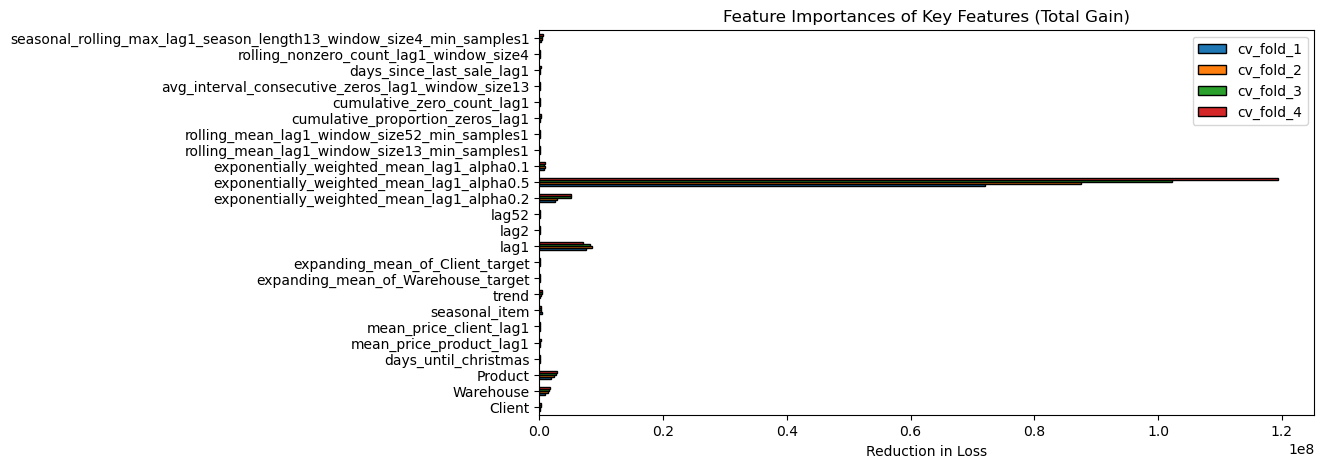

In [278]:
# lets keep features that are atleast meeting the median performance at all 4 folds 

medians = feature_importance_df.median()

mask = [feature_importance_df[f'cv_fold_{i}'] >= medians.loc[f'cv_fold_{i}'] for i in range(1,5)]

feat_filter = pd.concat(mask,axis=1).sum(axis=1)


#4 cv fold cutoff gave final ensemble score of .514, alter nothing else here! 

key_features = feat_filter[feat_filter >= 4].index.to_list()


#plot feature importances 

feature_importance_df.loc[key_features].plot.barh(title='Feature Importances of Key Features (Total Gain)',
                                                  edgecolor='black',
                                                  xlabel='Reduction in Loss')

In [279]:
#define a quick helper to split X and y and keep only the key features we found 

def make_x_y(df,key_features): 
    
    y = df['y']

    X = df[key_features]

    return X,y 

In [280]:
static_ids = ["Warehouse","Product",'Client']


#SET ML DF back to ml_df

ml_df = ml_df_

# preprocess again and slice these features 
dfp = mlf.preprocess(ml_df.to_pandas().sort_values('ds'),
               static_features=static_ids,
              # return_X_y=True,
               #as_numpy=True
               )

X, y = make_x_y(dfp,key_features=key_features + ['ds'])


X[static_ids] = X[static_ids].astype('category')


num_purchase[['Client','Warehouse','Product']] = num_purchase['unique_id'].str.split('-',expand=True)

# Create Train/Val/Test Split for tuning now.

 * here we are doing a quick train, val, test split to hold out two horizons. One for validation-tuning and the other for testing model performance.

In [281]:
pre = mlf.preprocess(ml_df.to_pandas().sort_values('ds'),
                     
               static_features=['Client','Warehouse','Product'])

test = pre.groupby('unique_id').tail(horizon)

X_test, y_test = make_x_y(test,key_features=key_features)

train = pre.drop(test.index)

X_train,y_train = make_x_y(train,key_features=key_features)

print(f'Train Max Date: {train["ds"].max()}, Test Min Date: {test["ds"].min()}')


#get new categorical indices to feed to lgbm 

cat_idxs = [X_train.columns.get_loc(col) for col in mlf.ts.static_features]


Train Max Date: 2023-07-03 00:00:00, Test Min Date: 2023-07-10 00:00:00


# LightGBM Training

* CV Procedure 

* we use the same 5 fold timeseries cross validation, this time only on the train set so we effectively tune our model over 5 folds of validation data

In [282]:
static_features = [x for x in key_features if x in ['Client','Warehouse','Product','seasonal_item','uid','one_time_sku']]

lag_feats = [x for x in key_features if 'lag' in x and 'rolling' not in x and 'exp' not in x and 'mean' not in x and 'zero' not in x]

rolling_feats = [x for x in key_features if 'rolling' in x or 'exp' in x]

date_feats = [x for x in key_features if x in ['year','week','month','quarter','days_in_month']]

exog_feats = [x for x in key_features if x not in static_features and x not in lag_feats and x not in date_feats and x not in rolling_feats]

#create dict 
feat_dict = dict(zip(['static','lag','rolling','date','exog'],[static_features,lag_feats,rolling_feats,date_feats,exog_feats]))

for feat_type, feat_list in feat_dict.items(): 

    print(f'Final Features: {feat_type}: {feat_list}')

Final Features: static: ['Client', 'Warehouse', 'Product', 'seasonal_item']
Final Features: lag: ['lag1', 'lag2', 'lag52', 'days_since_last_sale_lag1']
Final Features: rolling: ['expanding_mean_of_Warehouse_target', 'expanding_mean_of_Client_target', 'exponentially_weighted_mean_lag1_alpha0.2', 'exponentially_weighted_mean_lag1_alpha0.5', 'exponentially_weighted_mean_lag1_alpha0.1', 'rolling_mean_lag1_window_size13_min_samples1', 'rolling_mean_lag1_window_size52_min_samples1', 'rolling_nonzero_count_lag1_window_size4', 'seasonal_rolling_max_lag1_season_length13_window_size4_min_samples1']
Final Features: date: []
Final Features: exog: ['days_until_christmas', 'mean_price_product_lag1', 'mean_price_client_lag1', 'trend', 'cumulative_proportion_zeros_lag1', 'cumulative_zero_count_lag1', 'avg_interval_consecutive_zeros_lag1_window_size13']


In [283]:
#OUTLINE FORECAST HORIZON 
horizon = 13

lags_list = [1,2,3,52]


#THESE FEATURES WITH ENSEMBLE ACHIEVED SCORE OF .505 

key_features = ['Client',
 'Warehouse',
 'Product',
 'days_until_christmas',
 'price_expanding_mean_lag1',
 'mean_price_product_lag1',
 'seasonal_item',
 'trend',
 'expanding_mean_of_Warehouse_target',
 'expanding_mean_of_Product_target',
 'expanding_mean_of_Client_target',
 'lag1',
 'lag2',
 'lag3',
 'lag52',
 'exponentially_weighted_mean_lag1_alpha0.2',
 'rolling_mean_lag1_window_size52_min_samples1',
 'seasonal_rolling_mean_lag1_season_length13_window_size4_min_samples1',
 'rolling_skew_lag1_window_size13',
 'cumulative_proportion_zeros_lag1',
 'cumulative_zero_count_lag1',
 'avg_interval_consecutive_zeros_lag1_window_size13',
 'days_since_last_sale_lag1']



#name lag transform features 
def custom_namer(transform, lag, **kwargs):
    if isinstance(transform, ExponentiallyWeightedMean):
        return f"ewm_lag{lag}_alpha{transform.alpha}"
    elif isinstance(transform, SeasonalRollingMean):
        return f"srm_lag{lag}_season{transform.season_length}_window{transform.window_size}"
    elif isinstance(transform, SeasonalRollingStd):
        return f"srstd_lag{lag}_season{transform.season_length}_window{transform.window_size}"
    elif isinstance(transform, RollingQuantile):
        return f"rq_lag{lag}_window{transform.window_size}_p{transform.p}"
    else:
        return f"{transform.__class__.__name__}_lag{lag}"
    

#DEFINE NEW LIST OF WINDOW FEATURES 
window_feats = [

              ExponentiallyWeightedMean(alpha=.2),
              
                ExponentiallyWeightedMean(alpha=.5),

                                                        SeasonalRollingMean(window_size=4,
                                                        season_length=13,
                                                        min_samples=1),
                
                                                                    RollingMean(window_size=13,
                                                                                min_samples=1),

                                                                                RollingMean(window_size=52,
                                                                                            min_samples=1),

                                                                           days_since_last_sale,

                                                                           cumulative_proportion_zeros,

                                                                           cumulative_zero_count,

                                                                         (avg_interval_consecutive_zeros,13),

                                                                         (avg_interval_consecutive_zeros,52),

                                                                           count_positive_reset_on_zero,
                                                                           
                                                                          (rolling_skew,13)

                                                                          
                                                                        # (seasonal_exp_rolling_mean,13,0.3)
                                                                           ]




#create final df 

final_df = (ml_df
 
 .select([x for x in ml_df.columns if x in key_features or x in ['ds','unique_id','y','price_expanding_mean_lag1']])
 
 .to_pandas().sort_values('ds'))

print(final_df.head())

         Client  Warehouse  Product         ds    y     unique_id  \
0             0          1      367 2020-07-06  7.0       0-1-367   
1008270      16        196     1513 2020-07-06  0.0   16-196-1513   
217770        1         75    11201 2020-07-06  0.0    1-75-11201   
2221390      41        200     3558 2020-07-06  0.0   41-200-3558   
1421540      22        338    14293 2020-07-06  0.0  22-338-14293   

         days_until_christmas  price_expanding_mean_lag1  \
0                         172                        NaN   
1008270                   172                        NaN   
217770                    172                        NaN   
2221390                   172                        NaN   
1421540                   172                        NaN   

         mean_price_product_lag1  seasonal_item  trend  \
0                            NaN              0    1.0   
1008270                      NaN              1    1.0   
217770                       NaN              1   

In [284]:
X, y = mlf.preprocess(final_df,
               static_features=[],
               return_X_y=True)

X = X[key_features].to_numpy()

In [285]:
# import optuna
# from lightgbm import LGBMRegressor
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(n_splits=5) # optimize for long horizon forecasts 

# # Your dataset
# X_t, y_t = X, y

# def objective_lightgbm(trial):
#     # Define hyperparameters for LGBMRegressor
#     params = {
#         'objective':'tweedie',

#         'boosting_type': 'gbdt',

#        # 'max_depth': trial.suggest_int('max_depth', -1, 15),  # -1 means no limit

#         'num_leaves':trial.suggest_int('num_leaves', 80, 500),

#         'tweedie_variance_power':1.2, # optimize the shape of our objective, it seems in this case lower may be better (more tweedie than gamma dist)

#        'reg_alpha': trial.suggest_float('reg_alpha', .0001, 3,log=True),#regularization to prevent overfitting (l2 penalty)
        
#         'reg_lambda': trial.suggest_float('reg_lambda', .0001, 3,log=True), #regularization to prevent overfitting (l1 penalty)

#         'n_estimators':trial.suggest_int('n_estimators',200,600),

#           'cat_l2':trial.suggest_float('cat_l2',3,10),

#           'feature_fraction':trial.suggest_float('feature_fraction',.85,1),

#           'cat_smooth':trial.suggest_float('cat_smooth',8,15),

#            'verbosity':-1
#     }

#     # Cross-validation for LightGBM
#     cv_score = []

#     for train_index, val_index in tscv.split(X_t, y_t):
#         X_train, X_val = X_t[train_index], X_t[val_index]
#         y_train, y_val = y_t[train_index], y_t[val_index]

#         model = LGBMRegressor(**params)

#         model.fit(X_train, y_train,categorical_feature=cat_idxs)

#         y_pred = model.predict(X_val)
#         model_score = score_model(y_val, y_pred)
#         cv_score.append(model_score)

#     return np.mean(cv_score)

# def optimize():
#     study_lightgbm = optuna.create_study(direction='minimize')  
#     study_lightgbm.optimize(objective_lightgbm, n_trials=50)

#     # Collecting best results
#     best_lightgbm_trial = study_lightgbm.best_trial

#     best_params = {
#         "lightgbm_score": best_lightgbm_trial.value,
#         "lightgbm_params": best_lightgbm_trial.params,
#     }

#     return best_params

# if __name__ == "__main__":
#     best_hyperparameters_tweedie_sh = optimize()
#     print("Best LightGBM trial:")
#     print(f"  Score (MAE + Bias): {best_hyperparameters_tweedie_sh['lightgbm_score']:.4f}")
#     print("  Best hyperparameters:")
#     for key, value in best_hyperparameters_tweedie_sh['lightgbm_params'].items():
#         print(f"    {key}: {value}")

In [286]:
# import optuna
# from xgboost import XGBRegressor,XGBRFRegressor
# from sklearn.model_selection import TimeSeriesSplit
# import numpy as np

# tscv = TimeSeriesSplit(n_splits=5)  # Optimize for long horizon forecasts

# # Your dataset
# X_t, y_t = X, y

# def objective_xgboost(trial):
#     # Define hyperparameters for XGBRegressor
#     params = {
#         'objective': 'reg:squarederror',
#         'booster': 'gbtree',  # You can also use 'gblinear' or 'dart'
        
#         'max_depth': 8,  # Limit depth to avoid overfitting
#         'n_estimators': trial.suggest_int('n_estimators', 100, 600),
    
#         'subsample': trial.suggest_float('subsample', 0.5, .8),  # Proportion of samples to use
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Proportion of features to use
        
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 3, log=True),  # L1 regularization
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 3, log=True),  # L2 regularization

#         'enable_categorical':True,
        
#         'verbosity': 0
#     }

#     # Cross-validation for XGBoost
#     cv_score = []

#     for fold, (train_index, val_index) in enumerate(tscv.split(X_t, y_t)):
#         X_train, X_val = X_t[train_index], X_t[val_index]
#         y_train, y_val = y_t[train_index], y_t[val_index]

#         model = XGBRFRegressor(**params)

#         model.fit(X_train, y_train)

#         # Check if the trial should be pruned
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()

#         y_pred = model.predict(X_val)
#         model_score = score_model(y_val, y_pred)  # Ensure you have a scoring function
#         cv_score.append(model_score)


#         # Report intermediate results to Optuna
#         trial.report(model_score, fold)

#         # Check if the trial should be pruned
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()

#     return np.mean(cv_score)

# def optimize():
#     pruner = optuna.pruners.MedianPruner()
#     study_xgboost = optuna.create_study(direction='minimize',pruner=pruner)  
#     study_xgboost.optimize(objective_xgboost, n_trials=50)

#     # Collecting best results
#     best_xgboost_trial = study_xgboost.best_trial

#     best_params = {
#         "xgboost_score": best_xgboost_trial.value,
#         "xgboost_params": best_xgboost_trial.params,
#     }

#     return best_params

# if __name__ == "__main__":
#     best_hyperparameters_xgboost = optimize()
#     print("Best XGBoost trial:")
#     print(f"  Score (MAE + Bias): {best_hyperparameters_xgboost['xgboost_score']:.4f}")
#     print("  Best hyperparameters:")
#     for key, value in best_hyperparameters_xgboost['xgboost_params'].items():
#         print(f"    {key}: {value}")


In [287]:
cat_idxs = [final_df.columns.get_loc(x) for x in final_df.columns if x in ['uid','Client','Warehouse','Product']]


#overall fcst params
tuned_params = {'num_leaves': 250,
 'tweedie_variance_power': 1.1280166222543282,
 'max_bin': 173,
 'reg_alpha': 0.00020975364567322154,
 'reg_lambda': 0.05679928750688587,
 'learning_rate': 0.016100557085316106,
 'n_estimators': 426,
 'cat_l2': 5.461491237658411,
 'feature_fraction': 0.9390732973556362,
 'categorical_feature':cat_idxs,
 'cat_smooth': 13.990950475781716
 }


dir_mod = {'lgb_tweedie_dir':LGBMRegressor(objective='tweedie',
                                    **tuned_params,
                                    random_state=42,
                                    verbosity=-1)
    
    }

rec_mod = {'lgb_tweedie_rec':LGBMRegressor(objective='tweedie',
                                    **tuned_params,
                                    random_state=42,
                                    verbosity=-1)}


mlf_direct = MLForecast(
    
    models = dir_mod,

    freq='W-MON',

    lags = lags_list,

    lag_transforms={1:window_feats},

    date_features=date_feats,

    #lag_transforms_namer=custom_namer,

    num_threads=8
)


mlf_rec = MLForecast(
    models = rec_mod,
        
    freq='W-MON',

    lags = lags_list,

    lag_transforms={1:window_feats},

    date_features=date_feats + [week_contains_christmas],

    #lag_transforms_namer=custom_namer,

    num_threads=8
    
)

In [288]:
#read in stats future predictions and stats cv 
stat_preds = pd.read_csv('stats_preds_fut.csv',
                         parse_dates=['ds'])

sfcv = pd.read_csv('statsforecast_five_fold_cv.csv',
                   parse_dates=['ds','cutoff'])

stat_preds.head()

,unique_id,ds,croston,naive,auto_theta,mstl_all_seasons,ses_opt
0,0-1-367,2023-10-09,1.426694,0.0,1.586900,0.954602,1.672496
1,0-1-367,2023-10-16,1.426694,0.0,1.566401,0.379948,1.672496
2,0-1-367,2023-10-23,1.426694,0.0,1.545902,2.254231,1.672496
3,0-1-367,2023-10-30,1.426694,0.0,1.525402,2.163840,1.672496
4,0-1-367,2023-11-06,1.426694,0.0,1.504903,1.462875,1.672496


In [289]:
# mlf_rec.fit(final_df,
#         id_col='unique_id',
#         time_col='ds',
#         static_features=static_features)


# final_df[static_ids] = final_df[static_ids].astype('category')

# #this time we forecast recursively 
# mlf_cv_recursive = mlf_rec.cross_validation(df=final_df,
                              
#                 id_col='unique_id',
               
#                 time_col='ds',
                    
#                      n_windows=4,
                     
#                      h=horizon,
        
#                      step_size=horizon,
                    
#                      refit=True,

#                    #  as_numpy=True,

#                      static_features=static_features)



# print('Recursive Forecasting Completed...')

# final_df[static_ids] = final_df[static_ids].astype('category')

# # # #now we forecast directly 

# mlf_cv_direct = mlf_direct.cross_validation(df=final_df,
                              
#                 id_col='unique_id',
               
#                 time_col='ds',
                    
#                      n_windows=4,
                     
#                      h=horizon,
                    
#                      max_horizon=horizon, # direct forecasting
                    
#                      step_size=horizon,
                    
#                      refit=True,

#                      #as_numpy=True,

#                      static_features=static_features)



In [290]:
# mlf_cv_direct.to_csv('mlf_cv_direct.csv')

# mlf_cv_recursive.to_csv('mlf_cv_recursive.csv')

In [291]:
mlf_cv_direct = pd.read_csv('mlf_cv_direct.csv',
                     parse_dates=['ds','cutoff'],
                     usecols=['unique_id','ds','cutoff','y','lgb_tweedie_dir'])

mlf_cv_recursive = pd.read_csv('mlf_cv_recursive.csv',
                               parse_dates=['ds','cutoff',],
                     usecols=['unique_id','ds','cutoff','y','lgb_tweedie_rec'])

# nbeats_cv = pd.read_csv('nbeatsx_cv.csv',
#                         parse_dates=['ds','cutoff'])

In [292]:

from typing import Callable, List
from scipy import optimize 

def find_optimal_combination(
    candidates: List[str],
    pred_wide: pd.DataFrame,
    target: str,
    metric_fn: Callable = score_model,
    verbose=False) -> List[float]:
    """Runs an optimization to find the best weights with which the candidate forecasts can be combined in an average

    Args:
        candidates (List[str]): The list of str with ensemble candidate names
        pred_wide (pd.DataFrame): DataFrame with the forecasts and target in a wide format. Each forecast in a separate column.
        target (str): Column name of the target
        metric_fn (Callable, optional): The metric to be calculated on the resulting ensemble.

    Returns:
        List[float]: The optimal weights
    """

    def loss_function(weights):
        # fc = np.average(pred_wide[candidates], weights=weights, axis=1)
        # This is faster
        fc = np.sum(pred_wide[candidates].values * np.array(weights), axis=1)

        base_metric = metric_fn(pred_wide[target].values, fc)

        return base_metric
    


    loss_func =  loss_function

    constraints = [
        {"type": "eq", "fun": lambda w: 1 - sum(w)},   # Sum of weights must equal 1
    ]

    opt_weights = optimize.minimize(
        loss_func,
        x0=[1 / len(candidates)] * len(candidates),
        constraints=constraints,
        method="SLSQP",
        bounds=[(0.0, 1.0)] * len(candidates),
        options={"ftol": 1e-10},
    )
    if verbose:
        print(f'Optimization Min Score Over all Folds: {opt_weights["fun"]}')
    
    return opt_weights['x']


def forecast_bias(y_true,y_pred): 
    e = y_true - y_pred
    bias = np.sum(e) / np.sum(y_true)
    return bias * 100


* Evaluate Directional Bias of each fold, then bias + wape of each fold 

In [293]:

#merge cv dataframes 
comb_cv = (sfcv.merge(mlf_cv_recursive.drop('y',axis=1),
                        
                                on=['unique_id','ds','cutoff'],

                                how='left').merge(
                                    mlf_cv_direct.drop(columns=['y']),
                                    on=['unique_id','cutoff','ds']
                                ).fillna(0)
)



print(f'Unique Cutoffs: {comb_cv["cutoff"].unique()}')

comb_cv

Unique Cutoffs: <DatetimeArray>
['2022-10-03 00:00:00', '2023-01-02 00:00:00', '2023-04-03 00:00:00',
 '2023-07-03 00:00:00']
Length: 4, dtype: datetime64[ns]


,unique_id,ds,cutoff,y,croston,naive,auto_theta,mstl_all_seasons,ses_opt,lgb_tweedie_rec,lgb_tweedie_dir
0,0-1-367,2022-10-10,2022-10-03,0.0,3.496381,3.0,2.993737,3.972384,2.999997,2.634616,2.613653
1,0-1-367,2022-10-17,2022-10-03,1.0,3.496381,3.0,2.987539,4.434033,2.999997,2.629796,3.158608
2,0-1-367,2022-10-24,2022-10-03,2.0,3.496381,3.0,2.981342,4.569018,2.999997,2.584079,3.666752
3,0-1-367,2022-10-31,2022-10-03,5.0,3.496381,3.0,2.975144,3.912539,2.999997,2.553829,3.940703
4,0-1-367,2022-11-07,2022-10-03,1.0,3.496381,3.0,2.968947,3.949618,2.999997,2.546716,3.685895
...,...,...,...,...,...,...,...,...,...,...,...
746871,46-318-14294,2023-09-04,2023-07-03,4.0,5.154367,4.0,5.108055,4.952264,4.839589,4.773507,8.423669
746872,46-318-14294,2023-09-11,2023-07-03,3.0,5.154367,4.0,5.134509,4.831333,4.839589,5.045889,7.960961
746873,46-318-14294,2023-09-18,2023-07-03,5.0,5.154367,4.0,5.160964,4.452896,4.839589,5.050226,9.124634
746874,46-318-14294,2023-09-25,2023-07-03,0.0,5.154367,4.0,5.187418,4.601079,4.839589,5.038828,8.486245


In [294]:
total_dmd = comb_cv.groupby('unique_id')[['y']].sum().sort_values(by='y')


new_sparse = total_dmd[total_dmd['y'] == 0].index

In [295]:
candidates = ['lgb_tweedie_rec','lgb_tweedie_dir','auto_theta','mstl_all_seasons']

comb_cv[candidates] = comb_cv[candidates].clip(lower=0) # clip all models to have max lower bound of zero

comb_cv.loc[comb_cv['unique_id'].isin(sparse_ids),candidates] = 0  # zero out all sparse id predictions 

ensemble_one = find_optimal_combination(pred_wide=comb_cv,target='y',candidates=candidates,verbose=True)

comb_cv['ensemble_one'] = np.dot(comb_cv[candidates], ensemble_one)

candidates_two =  ['lgb_tweedie_rec','auto_theta']

ensemble_two = find_optimal_combination(pred_wide=comb_cv,target='y',candidates = candidates_two,verbose=True)

comb_cv['ensemble_two'] = np.dot(comb_cv[candidates_two], ensemble_two)

Optimization Min Score Over all Folds: 0.49940152506330904
Optimization Min Score Over all Folds: 0.5042465542384582


In [296]:
import warnings 

warnings.filterwarnings('ignore')

In [297]:
model_list = comb_cv.drop(columns=['cutoff','ds','y','unique_id']).columns.tolist()

#define strong models as models that aren't aren't naive
strong_models = [x for x in model_list if 'naive' not in x]

for model in strong_models: 
#print mean performance for all models 
    cv_metric = score_model(comb_cv['y'],comb_cv[model])

    print(f'Pooled Score for {model}: {cv_metric:.5f}')

Pooled Score for croston: 0.63925
Pooled Score for auto_theta: 0.53427
Pooled Score for mstl_all_seasons: 0.55836
Pooled Score for ses_opt: 0.56332
Pooled Score for lgb_tweedie_rec: 0.51792
Pooled Score for lgb_tweedie_dir: 0.59843
Pooled Score for ensemble_one: 0.49940
Pooled Score for ensemble_two: 0.50425


In [298]:
meltd_cv = comb_cv.melt(id_vars=['unique_id','ds','cutoff','y'],
                                                var_name='fcst',
                                                value_name='y_pred')

tab = meltd_cv.groupby(['fcst','cutoff']).apply(lambda group: {'score':score_model(group['y'],group['y_pred']),
                                                         'bias':forecast_bias(group['y'],group['y_pred'])}).reset_index(name='MAE+Bias')



eval_table = pd.concat([tab[['fcst','cutoff']],pd.json_normalize(tab['MAE+Bias'])],axis=1)

eval_table.pivot_table(index='cutoff',
                       columns='fcst',
                       values='score')

fcst,auto_theta,croston,ensemble_one,ensemble_two,lgb_tweedie_dir,lgb_tweedie_rec,mstl_all_seasons,naive,ses_opt
cutoff,,,,,,,,,
2022-10-03,0.772605,0.882253,0.662270,0.680480,0.822390,0.665242,0.694638,0.851830,0.835060
2023-01-02,0.681099,0.705366,0.682358,0.716909,0.552033,0.762628,0.620073,0.695475,0.681482
2023-04-03,0.454204,0.529335,0.479740,0.483929,0.496604,0.518732,0.522873,0.505620,0.476276
2023-07-03,0.495220,0.555824,0.474838,0.466305,0.517281,0.476648,0.583854,0.524666,0.498737


# Prepare Future DataFrame. 

* notice that direct prediction does quite well in january, while recursive does very bad.... in the above table. My best score of .511 (Phase One) was achieved with direct prediction

In [299]:
def make_future_prices(fut_df, prices_df):

    fut_df = fut_df.with_columns(pl.col('unique_id').cast(pl.Categorical))

    prices = (prices_df

    .with_columns(pl.concat_str(['Client','Warehouse','Product'], 
                                    separator='-').alias('unique_id').cast(pl.Categorical),

                                    pl.col('y').cast(pl.Float64).alias('price'),
                                    

                                    #get weekly price avg over unique_id 
                                    pl.col('ds').dt.week().alias('week')) 
                                     
                                      .group_by(['Client','Product','unique_id','week'])

                                        .agg(pl.col('price').mean())

                                                    .with_columns(pl.col('price')
                                                    
                                                    .fill_null(strategy='mean').over('unique_id'))

                                                    .with_columns(pl.when(pl.col('price') != 0).then(pl.col('price').diff().over('unique_id') / pl.col('price')).otherwise(0).alias('price_diff_rel'),
                                                                  
                                                                  pl.col("price").diff(4).over('unique_id').alias('monthly_price_shift'))
    )


    prod_stats = prices.group_by('Product','week').agg(pl.col('price').mean().alias('mean_price_product_lag1'))

    client_stats = (prices.group_by('Client','week')
                    
                    .agg(pl.col('price').mean().alias('mean_price_client_lag1'))
                    
                    .with_columns(pl.col('mean_price_client_lag1').shift(4).alias('mean_price_client_lag4'))
    )

    fut_prices_final = (fut_df.with_columns(pl.col('ds').dt.week().alias('week')).join(
        
        prices,

        on=['unique_id','week']

    )
    .with_columns((pl.col('price') - pl.col('price').shift(1).over('unique_id')).alias('price_diff'))
    
    .with_columns(pl.col('price_diff').shift(52).alias('ly_price_diff'),
                  
                   pl.col('price').shift(52).alias('ly_price_shift'),
                   
                   pl.col('price').mean().over('unique_id').alias('price_expanding_mean_lag1'))
     
     
     .join(
         prod_stats,
         on=['Product','week']
     )
     
     .join(
         client_stats,
         on=['Client','week']
     ))
    

    return fut_prices_final



In [300]:
#fit ML Models 
X, y = mlf.preprocess(final_df,
               static_features=static_features,
               return_X_y=True,
               as_numpy=True)

#MAKE FUTURE FRAME
future = mlf.make_future_dataframe(h=13)

#pull out key price features 

key_price_features = [x for x in key_features if 'price' in x]

#make future price feature
exog_ = make_future_prices(fut_df=fut_df,prices_df=prices_).select(['unique_id','ds','trend'] + key_price_features)

In [301]:
exog_final = make_holiday_counter(exog_,holiday_day=25,holiday_month=12,holiday_name='christmas') # make days until christmas feature

#exog_final = rbf_features(exog_final,week_data=exog_final['ds'].dt.week(),centers=[28])

exog_final.head()

unique_id,ds,trend,price_expanding_mean_lag1,mean_price_product_lag1,days_until_christmas
cat,date,f64,f64,f64,i64
"""34-325-10957""",2023-11-27,178.0,24.600538,28.0,28
"""23-333-10185""",2023-11-20,177.0,6.0,6.0,35
"""26-8-11882""",2023-11-27,178.0,19.490385,19.76303,28
"""28-144-8445""",2023-10-09,171.0,160.432788,159.965625,77
"""41-143-8239""",2023-10-30,174.0,16.488291,16.44482,56


In [302]:
final_df[static_ids] = final_df[static_ids].astype(str)

rolling_feats = [make_expanding_mean_features(pl.from_pandas(final_df),id_col=x).to_pandas() for x in static_ids]

final_df[static_ids] = final_df[static_ids].astype('category')

old_expanding_cols = final_df.filter(like='expanding').columns 


final_df = final_df.drop(columns=old_expanding_cols).merge(
    
    rolling_feats[0],
    
    on=[static_ids[0], 'ds']
).merge(

    rolling_feats[1],

    on=[static_ids[1], 'ds']
).merge(

    rolling_feats[2],

    on=[static_ids[2], 'ds']
)

In [303]:
last_expanding = final_df.groupby(['unique_id'])[['expanding_mean_of_Warehouse_target', # join in expanding means of hierarchy categories (Warehouse, Client, Product)
                                                  'expanding_mean_of_Product_target',
                                                  'expanding_mean_of_Client_target']].last().reset_index()



exog_final = exog_final.join(
            pl.from_pandas(last_expanding),
            on=['unique_id'],
            how='left'
            )

In [304]:
#specify recursive forecasting method this time 
final_df[static_ids] = final_df[static_ids].astype('category')


mlf_rec.fit(final_df,
        #max_horizon=horizon,
        #as_numpy=True,
        id_col='unique_id',
        time_col='ds',
        static_features=static_features)


#predict using direct methods 
ml_rec_preds = mlf_rec.predict(h=horizon,
                                X_df = exog_final.to_pandas())



#prepare validation set and score model against it 

val_set = val_set.with_columns(pl.concat_str('Client','Warehouse','Product',separator='-').alias('unique_id'))

valid_frame = val_set.to_pandas().merge(
    ml_rec_preds,

    on=['unique_id','ds'],

    how='left').fillna(0) # fill sparse ids with zero 

valid_score_rec = score_model(valid_frame['y'],valid_frame['lgb_tweedie_rec'])


print(f'Tweedie LGBM Recursive Prediction Score: {valid_score_rec:.3f}')

Tweedie LGBM Recursive Prediction Score: 0.516


In [305]:
#specify direct forecasting method this time 
mlf_direct.fit(final_df,
        max_horizon=horizon,
        as_numpy=True,
        id_col='unique_id',
        time_col='ds',
        static_features=static_features)


#predict using direct methods 
ml_dir_preds = mlf_direct.predict(h=horizon,
                       X_df = exog_final.to_pandas())


valid_frame = val_set.to_pandas().merge(
    
    ml_dir_preds,
    
    on=['unique_id','ds'],
    
    how='left'
).fillna(0)


valid_score_dir_short = score_model(valid_frame['y'],valid_frame['lgb_tweedie_dir'])


print(f'Tweedie LGBM Direct Prediction Score: {valid_score_dir_short:.3f}')

Tweedie LGBM Direct Prediction Score: 0.579


In [306]:
#merge all predictions and validation set as "ensemble df"

ens_df = (stat_preds
          
          .merge(ml_rec_preds,
                 
                 on=['unique_id','ds'],

                 how='left')
            .merge(
                ml_dir_preds,
                on=['unique_id','ds'],

                how='right'
            )

       .merge(val_set.to_pandas(),
              
             on=['unique_id','ds'])
             
             .fillna(0))


ens_df

,unique_id,ds,croston,naive,auto_theta,mstl_all_seasons,ses_opt,lgb_tweedie_rec,lgb_tweedie_dir,Client,Warehouse,Product,y
0,0-1-367,2023-10-09,1.426694,0.0,1.586900,0.954602,1.672496,1.546656,1.508502,0,1,367,1.0
1,0-1-367,2023-10-16,1.426694,0.0,1.566401,0.379948,1.672496,1.450420,1.600908,0,1,367,1.0
2,0-1-367,2023-10-23,1.426694,0.0,1.545902,2.254231,1.672496,1.503667,1.723919,0,1,367,1.0
3,0-1-367,2023-10-30,1.426694,0.0,1.525402,2.163840,1.672496,1.473762,1.501190,0,1,367,2.0
4,0-1-367,2023-11-06,1.426694,0.0,1.504903,1.462875,1.672496,1.553749,1.636341,0,1,367,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186714,46-318-14294,2023-12-04,3.033903,0.0,0.975179,-0.574341,0.915121,3.091047,2.830806,46,318,14294,0.0
186715,46-318-14294,2023-12-11,3.033903,0.0,0.981159,0.328747,0.915121,3.075686,2.687295,46,318,14294,1.0
186716,46-318-14294,2023-12-18,3.033903,0.0,0.987140,0.937014,0.915121,3.053623,2.320366,46,318,14294,1.0
186717,46-318-14294,2023-12-25,3.033903,0.0,0.993120,1.509289,0.915121,2.859790,2.580607,46,318,14294,1.0


In [307]:
#Test both of our ensemble DFs on the holdout set
all_models = ['auto_theta', 'mstl_all_seasons',
       'ses_opt', 'lgb_tweedie_rec'] 

ens_df[all_models] = ens_df[all_models].clip(lower=0)

ens_df = ens_df.assign(ens_one = np.dot(ens_df[candidates], ensemble_one),
              ens_two = np.dot(ens_df[candidates_two], ensemble_two))

#slice to test on validation period 
subset = ens_df[ens_df['ds'] >= val_set.to_pandas()['ds'].min()]

one_score = score_model(subset['y'],subset['ens_one'])

two_score = score_model(subset['y'],subset['ens_two'])

print(f'Ensemble One Score: {one_score:.5f}, Ensemble Two Score: {two_score:.5f}') # it looksl ike recursive lgbm and theta did the heavy lfiting in the ensemble 

Ensemble One Score: 0.51217, Ensemble Two Score: 0.50821


* define functions to apply ensemble weights in a vectorized way, then make submission format 

In [308]:
def apply_weights(pred_wide, models, optimal_weights, id_col):
    """
    Applies weights to predictions for each client and returns a DataFrame
    with the weighted predictions.

    Parameters:
    - pred_wide (DataFrame): DataFrame containing predictions.
    - models (list): List of column names with model predictions.
    - optimal_weights (dict): Dictionary of client IDs to their corresponding weights.
    - id_col (str): Name of the column that identifies clients.

    Returns:
    - DataFrame: Original DataFrame with an additional column for weighted predictions.
    """

    # Create a DataFrame from optimal weights for easier manipulation
    weight_df = pd.DataFrame.from_dict(optimal_weights, orient='index', columns=models).reset_index()
    weight_df.columns = [id_col] + models  # Rename columns appropriately

    # Merge weights with predictions
    merged_df = pred_wide.merge(weight_df, on=id_col, suffixes=('', '_weight'))

    # Calculate weighted predictions
    merged_df['weighted_prediction'] = (
        merged_df[models].values * merged_df[[x + '_weight' for x in models]].values
    ).sum(axis=1)

    select_cols = [x for x in merged_df.columns if "_weight" not in x]

    final = merged_df[select_cols]

    return final


# Apply some data wrangling to ensure everything is in the expected format of the competition

def make_sub(y_hat_df, name='sub_one'):
    # Assign the input DataFrame to yhat_test
    yhat_test = y_hat_df.copy()  # Ensure you have a working copy

    # Split 'unique_id' into 'Client', 'Warehouse', and 'Product'
    yhat_test[["Client", "Warehouse", "Product"]] = yhat_test["unique_id"].str.split("-", expand=True)

    # Convert to integer types
    yhat_test[["Client", "Warehouse", "Product"]] = yhat_test[["Client", "Warehouse", "Product"]].astype(np.int64)

    # Sort and reset index
    yhat_test = yhat_test.sort_values(by=["Client", "Warehouse", "Product"]).reset_index(drop=True)

    yhat_test = yhat_test.set_index(["Client", "Warehouse", "Product", "ds"]).drop('unique_id',axis=1)

    yhat_test = yhat_test.unstack(3)    

    yhat_test.columns = yhat_test.columns.get_level_values(1)   

    # You might want to save the DataFrame or return it here
    # e.g., return yhat_test or save it as a CSV
    return yhat_test

* iterate through all products, applying a custom weighted ensemble to each.

In [309]:
# from tqdm import tqdm 

# #make regularized ensemble 
# uid_wts = {}

# model_list = ['lgb_tweedie_rec','auto_theta','mstl_all_seasons','ses_opt']

# comb_cv[model_list] = comb_cv[model_list].clip(lower=0) # clip all model preds, we shouldn't be optimizing our forecast with negative candidates 

# #add product column 
# comb_cv['Product'] = comb_cv['unique_id'].str.split('-',expand=True)[2]

# #ensemble for each product 
# unique_products = comb_cv['Product'].unique()

# for uid in tqdm(unique_products,desc='Optimizing Ensemble For All Skus'): 

#     subset = comb_cv[(comb_cv['Product'] == uid)]

#     wts = find_optimal_combination(candidates=model_list,
#                          pred_wide=subset, # optimize ensemble for that subset (sku)
#                         target='y',
#                         metric_fn=score_model) # minimize our objective function of interest 
    
#     uid_wts[uid] = wts 


In [310]:
# wtd_preds = apply_weights(pred_wide=ens_df.assign(Product = ens_df['Product'].astype(str)),
#               models=model_list,optimal_weights=uid_wts,id_col='Product')

# #subset to test model on validation set only 
# subset=  wtd_preds[wtd_preds['ds'] > val_set.to_pandas()['ds'].min()]

# score_model(subset['y'],subset['weighted_prediction']) # this would've been my phase one score "val_set" is phase one test<<< 

In [311]:
# ensemble_two = apply_weights(pred_wide=comb_cv,optimal_weights=uid_wts,models=model_list,id_col='Product')

# localized_soft_ensemble = score_model(ensemble_two['y'],ensemble_two['weighted_prediction'])

# print(f'Four Model Ensemble of {model_list}, Final Score on 5 Fold CV is: {localized_soft_ensemble:.5f}')

# # ensemble_two.groupby('cutoff').apply(lambda x: score_model(x['y'],x['weighted_prediction']))

# # local_ensemble_pred = apply_weights(pred_wide=all_preds,optimal_weights=uid_wts,models=['lgb_tweedie','auto_theta','mstl_all_seasons','ses_opt'],id_col='Product')

# # make_sub(local_ensemble_pred[['unique_id','ds','weighted_prediction']]).to_csv('product_level_ensemble_pred.csv')

In [312]:
# combine ml_df and val_set, to forecast ahead
stat_df = pl.concat([ml_df.select('unique_id','ds','y'),
                     val_set.select('unique_id','ds','y')],
                     how='diagonal_relaxed').with_columns(pl.col('unique_id').cast(pl.Categorical))

stat_df

unique_id,ds,y
cat,date,f64
"""0-1-367""",2020-07-06,7.0
"""0-1-367""",2020-07-13,7.0
"""0-1-367""",2020-07-20,7.0
"""0-1-367""",2020-07-27,7.0
"""0-1-367""",2020-08-03,7.0
…,…,…
"""46-318-13485""",2024-01-01,0.0
"""46-318-13582""",2024-01-01,67.0
"""46-318-13691""",2024-01-01,2.0


In [313]:
from statsforecast.models import OptimizedTheta, MSTL, SimpleExponentialSmoothingOptimized
from statsforecast import StatsForecast


horizon = 13

models = [SimpleExponentialSmoothingOptimized(alias='ses'),

          MSTL(season_length=[13,52],
               alias='mstl_quarterly_yearly'),

          OptimizedTheta(decomposition_type='additive',
                         alias='theta')

          ]


sf = StatsForecast(models=models,
                   freq='1w',
                   n_jobs=-1)


#fit to train set 
sf.fit(df = stat_df.select('unique_id','ds','y'))

#predict to test set
stat_predict = sf.predict(h=horizon)

In [410]:
final_frame = stat_df.to_pandas().merge(
    
    final_df[['unique_id','Client','Warehouse','Product','seasonal_item']].drop_duplicates(subset='unique_id'),
    
    on=['unique_id']
)

In [411]:
rolling_feats = [make_expanding_mean_features(pl.from_pandas(final_frame),id_col=x).to_pandas()
                  for x in static_ids]

final_frame = final_frame.merge(
    
    rolling_feats[0],
    
    on=[static_ids[0], 'ds']
).merge(

    rolling_feats[1],

    on=[static_ids[1], 'ds']
).merge(

    rolling_feats[2],

    on=[static_ids[2], 'ds']
)


#make total prices frame 
total_prices = pl.concat([prices_,val_prices],
                         how='vertical_relaxed').with_columns(pl.col('y').cast(pl.Float64),
                                                              pl.col(pl.Int64).cast(pl.String).cast(pl.Categorical))


#transofrm prices and slice for the features we need 
final_frame = transform_prices(price_df=total_prices,
                 
                 target_df=pl.from_pandas(final_frame)
                    .with_columns(pl.col('ds').cast(pl.Date)))


#make christmas feature 
final_frame = make_holiday_counter(df=final_frame,holiday_day=25,holiday_month=12,holiday_name='christmas')


final_frame, fut_exog = trend(df=final_frame,
                              freq='1w',
                              h=13)

#final dataframe, slice for important features 
final_frame = final_frame.select(final_df.columns).to_pandas()


#make future christmas counter 
fut_exog = make_holiday_counter(fut_exog,holiday_day=25,holiday_month=12,holiday_name='christmas')

#get future exog features 
expanding_feats_fut = final_frame.groupby('unique_id').last().drop(columns=['ds','trend','y','days_until_christmas','Client','Warehouse','Product'])


fut_exog_final = fut_exog.to_pandas().merge(
    expanding_feats_fut,
    on=['unique_id']
)

In [418]:
mlf_rec.fit(final_frame,
            static_features=static_ids)

ml_preds = mlf_rec.predict(h=13,
                X_df=fut_exog_final)

In [428]:
total_fut_preds = stat_predict.to_pandas().merge(
    ml_preds,
    on=['unique_id','ds'],
    how='left'
).fillna(0).rename(columns={'theta':'auto_theta'})

In [432]:
total_fut_preds['y_pred'] = np.dot(total_fut_preds[candidates_two],ensemble_two)

make_sub(total_fut_preds[['unique_id','ds','y_pred']]) # make final submission

ds                        2024-01-08  2024-01-15  2024-01-22  2024-01-29  \
Client Warehouse Product                                                   
0      1         367        0.356998    0.387761    0.455490    0.450783   
                 639        3.952487    3.592355    3.991574    3.639499   
                 655        2.910589    3.375052    3.424265    3.555208   
                 1149       0.677443    0.682405    0.669230    0.669153   
                 1485       4.933636    5.422996    5.302581    5.361478   
...                              ...         ...         ...         ...   
46     318       13485      2.762125    4.611080    6.811267    8.281127   
                 13582     60.765723   60.508945   60.654232   64.700432   
                 13691      2.305143    2.700977    3.037975    3.244075   
                 13946      0.685132    0.839406    0.999480    1.252088   
                 14294      2.517398    2.571159    2.568194    2.624755   

ds                        2024-02-05  2024-02-12  2024-02-19  2024-02-26  \
Client Warehouse Product                                                   
0      1         367        0.442422    0.456865    0.473494    0.450943   
                 639        3.566793    3.580934    4.002548    3.856237   
                 655        3.479445    3.145196    3.648970    3.679265   
                 1149       0.656865    0.663057    0.648711    0.640172   
                 1485       5.629737    5.638286    5.720691    5.793855   
...                              ...         ...         ...         ...   
46     318       13485      9.994598   11.392345   13.095501   14.331246   
                 13582     69.891362   73.143864   77.530209   80.852869   
                 13691      3.541597    3.970001    4.237971    4.372423   
                 13946      1.460149    1.685909    1.831276    1.933024   
                 14294      2.764563    2.733154    2.735488    2.754365   

ds                        2024-03-04  2024-03-11  2024-03-18  2024-03-25  \
Client Warehouse Product                                                   
0      1         367        0.481210    0.470321    0.484012    0.471056   
                 639        3.655334    3.942720    3.651987    3.575276   
                 655        3.098873    3.662436    3.610299    3.317890   
                 1149       0.643620    0.650440    0.635020    0.633704   
                 1485       5.807525    6.140170    6.533956    6.261697   
...                              ...         ...         ...         ...   
46     318       13485     15.195697   16.301869   18.203731   18.816820   
                 13582     82.396057   85.387270   86.317009   87.941118   
                 13691      4.549060    4.599049    4.540004    4.608606   
                 13946      1.817770    1.822628    1.844113    1.863332   
                 14294      2.757399    2.794250    3.077556    3.051820   

ds                        2024-04-01  
Client Warehouse Product              
0      1         367        0.470082  
                 639        3.759074  
                 655        3.266831  
                 1149       0.629235  
                 1485       6.394635  
...                              ...  
46     318       13485     19.348616  
                 13582     90.009657  
                 13691      5.265353  
                 13946      1.885799  
                 14294      3.053057  

[15053 rows x 13 columns]

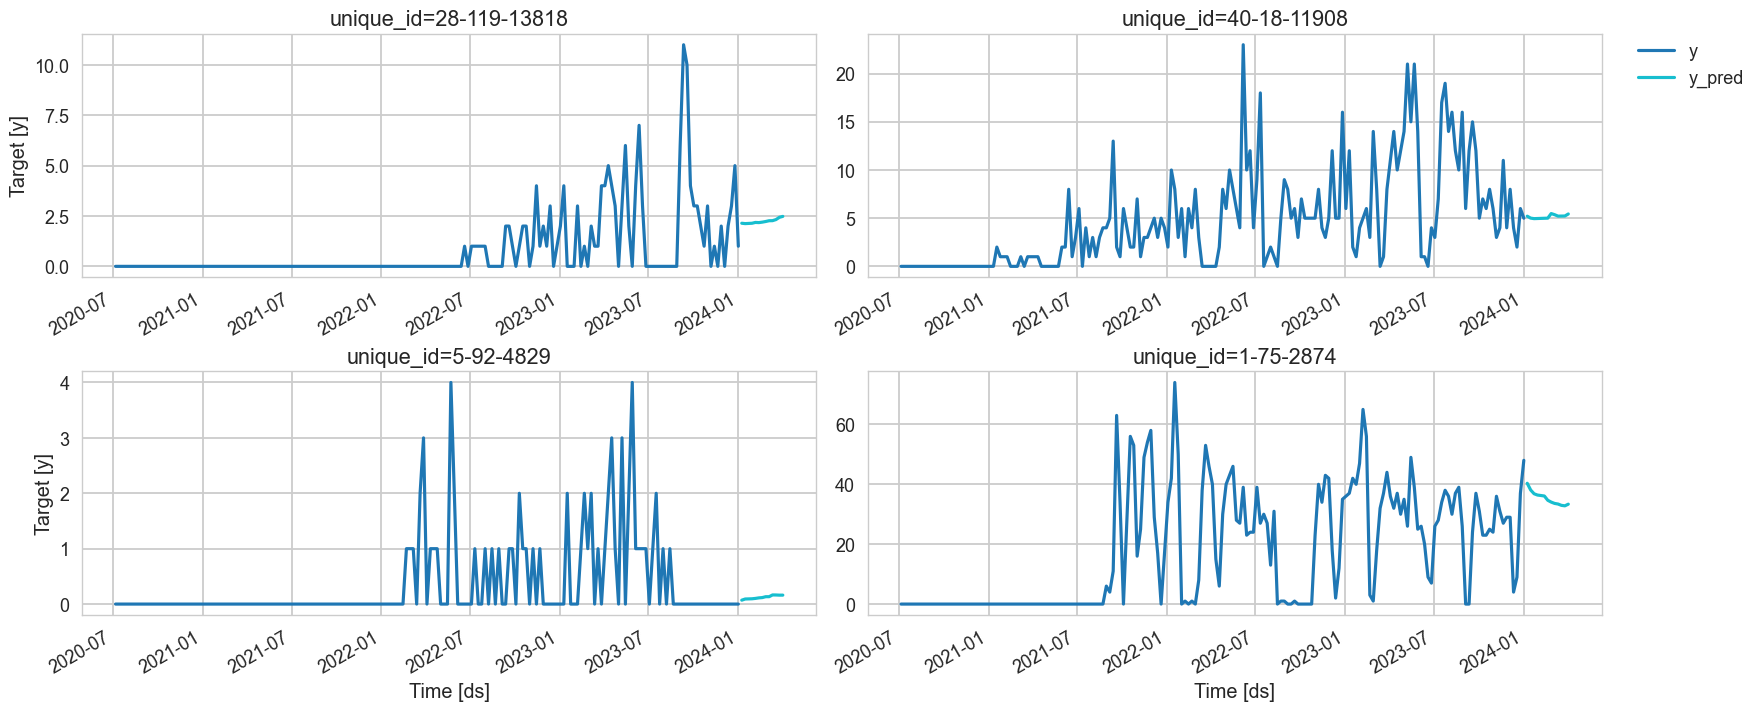

In [510]:
from utilsforecast.plotting import plot_series
plt.style.use('seaborn-v0_8-whitegrid')

plot_series(df=final_frame,
            forecasts_df=total_fut_preds,
            models=['y_pred'],
            max_ids=4,
            plot_random=True,
            seed=np.random.choice(50))